In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import compress

In [29]:
df_words = pd.read_json("words.json", orient="index")
total_sol = list(filter(None, list(df_words.loc["solutions"].values)))
total_guess = list(filter(None, list(df_words.loc["herrings"].values)))
total_guess = total_guess + total_sol

### Replicating the board

Let's make a function that does what the wordle board does and "colours" (using numbers) the squares. To do this we will use 2 = green (correct position), 1 = yellow (correct letter, wrong position), 0 = black (wrong letter).

However, we need to understand first some ambiguity  about how you deal with multiple letters. The aim here is to replicate what wordle does, so let's check


What happens when you use a double letter in a guess and there is only a single version of that letter in the answer? It's probably not a smart move to use double letters and you generally get less information but clearly the answer may have double letters so it will sometimes be necessary.

![slump.png](slump.png "Experimenting with multiple letters")

Experimenting as above (solution was "slump"), the logic seems to be:
- loop through all letters checking letter is correct place then colour it green, if you colour green, remove this letter from the set to be checked
- loop through **remaining** letters checking letter is in word but not correctly placed and colour it yellow, if you colour yellow, remove from the set to be checked

E.g.

answer = slump

guess = poppy, respose = ybbbb

guess = plump, response = bgggg

If you guess two of the same letter in a word that has that letter pair but both are in the wrong place I don't know what happens (ideally double yellow).

### Function for comparing guess with solution

In [3]:
def try_word(word, solution):
    word_list = [lett for lett in word]
    sol_list = [lett for lett in solution]
    out_list = [0, 0, 0, 0, 0]
    for n in range(len(word_list)):
        if word_list[n] == sol_list[n]:
            out_list[n] = 2
            word_list[n] = " "
            sol_list[n] = "_" #ugly
        else:    
            out_list[n] = 0

    #double loop because that is how the logic appears to work behind the scenes
    for n in range(len(word_list)):
        if word_list[n] in sol_list:
            out_list[n] = 1
            sol_list[sol_list.index(word_list[n])] = "_"

    return out_list


Let's run a test to check we get the same as the grid above.

In [4]:
solution = "slump"

words_eg = ["apple", "plump", "pipet", "poppy", "chess", "slams"]
for word in words_eg:
    scores = try_word(word, solution)    
    print(scores)

[0, 1, 0, 1, 0]
[0, 2, 2, 2, 2]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[2, 2, 0, 2, 0]


We do, so the logic looks ok at least for this small (but carefully selected!) set.

### Expressing current knowledge

We need to find a way to store what we know about the possible solutions, and it isn't immediately obvious to me the best way of doing that.

A suggestion from the everwise STPR is to just refilter the full list of words each time, which is probably efficient (since you have to do that anyway before making a guess), so let's make a function that takes in a list of words and filters them based on the scoring function above.

Input will be 
* list of numerical scores as above
* the assoicated word which gave those scores
* the working list of cromulent words

Output will be
* new shorter list of cromulent words

To match how the scoring works we will use the same logic described in "replicating the board"

In [5]:
#lots of gymnastics to deal with double letters. They are removed from guess and word list to avoid confusion as we go along
#ideally this would be much faster, I presume the cost is looping though the word list for every letter of every guess and splitting strings
#I'll redo it in pandas later, and optimistically give the function and "_fast" suffix
#update, I did it in pandas and it is much slower

def word_filter(scores, word, word_list_try):
    wl = np.array(word_list_try.copy())
    wl_work = np.array(wl.copy())
    for score,letter,i in zip(scores,word,range(len(scores))):
        tf = []
        if score == 2:
            for w in wl_work:
                if w[i] != letter:
                    tf.append(False)
                else:
                    tf.append(True)
                    
            wl = wl[tf]
            wl_work = wl_work[tf]
            word = word[:i] + " " + word[i+1:]
            for w,n in zip(wl_work,range(len(wl_work))):
                wl_work[n] = w.replace(letter, " ", 1)

    for score,letter,i in zip(scores,word,range(len(scores))):
        if letter == " ":
            continue
        tf = []
        if score == 1:
            for w in wl_work:
                fl = w.find(letter)
                if fl < 0:
                    tf.append(False)
                elif fl == i:
                    tf.append(False)
                else:
                    tf.append(True)  
            wl = wl[tf]
            wl_work = wl_work[tf]
            word = word[:i] + " " + word[i+1:]
            for w,n in zip(wl_work,range(len(wl_work))):
                wl_work[n] = w.replace(letter, " ", 1)
   
    for score,letter,i in zip(scores,word,range(len(scores))):
        if letter == " ":
            continue
        tf = []
        if score == 0:
            for w in wl_work:
                if w.find(letter) >= 0:
                    tf.append(False)
                else:
                    tf.append(True)  
            wl = wl[tf]
            wl_work = wl_work[tf]

    return wl    

### Let's Play Wordle
Below we play wordle n time for a list of words, calculate the xW (expected number of tries for a correct guess) and xW standard deviation. We also plot the histogram.

In [18]:
#list of words (or use words_master)

#active_list = total_sol.copy()
active_list = ["shard"]

#number of runs per word

n = 1000

counter_list = []

for mst_word in active_list[:]:
    counter = []

    for a in range(n):
        print(mst_word, a, end='\r', flush=False)
        words = total_guess
        answer = mst_word
        guess = random.choices(words)[0]
        guess = "least"
        cnt = 1
        while guess != answer:
            score = try_word(guess, answer)
            words = word_filter(score, guess, words)
            guess = random.choices(words)[0]
            cnt += 1
        counter.append(cnt)
    counter_list.append([answer, counter])

counter_list
df_dat = pd.DataFrame(counter_list)
df_dat

,0,1
0,shard,"[4, 6, 7, 6, 4, 3, 7, 6, 5, 3, 5, 4, 5, 4, 6, ..."


In [19]:
a = df_dat[1][0]
#a = df_dat.loc[df_dat[0] == active_list[0],1]
#a = list(a.values)[0]
xW, xW_sd = sum(a)/len(a), np.std(a)
print(f"xW: {xW:.2f}, xW_sd: {xW_sd:.2f}")

xW: 5.04, xW_sd: 1.15


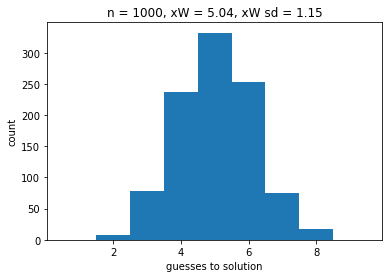

In [20]:
plt.hist(a, bins=np.arange(0.5,10.5))
title = "n = " + str(n) + ", xW = {xW:.2f}, xW sd = {xW_sd:.2f}"
plt.title(title.format(xW = xW, xW_sd = xW_sd))
plt.xlabel("guesses to solution")
plt.ylabel("count");

In [22]:
print(f"Probability <2 guesses: {sum([b<3 for b in a])/len(a):.1%}")

Probability <2 guesses: 0.7%


## Appendix

### Faster Function!
Here is the attempt at a function that runs faster than the one above.  
Is it shorter? Yes    
Is it prettier? Perhaps     
Is it faster? No    

In [180]:
def word_filter_fast(scores, word, word_list_try):
    cols = [i for i in range(5)]
    wl = pd.DataFrame(word_list_try, columns=["words"])
    wl["list"] = wl["words"].apply(list)
    wl = wl.join(pd.DataFrame(wl["list"].to_list(), columns = cols))
     
    for score,letter,i in zip(scores,word,range(len(scores))):
        if score == 2:
            wl = wl[wl[i] == letter]
            wl[i] = wl[i].replace(letter, " ")

    for score,letter,i in zip(scores,word,range(len(scores))):
        if score == 1:
            wl = wl[(wl[cols[:i]+cols[i+1:]] == letter).any(axis = 1)]
            wl = wl.where(((wl == letter).cumsum(axis=1).cumsum(axis=1) != 1), " ")

    for score,letter,i in zip(scores,word,range(len(scores))):
        if score == 0:
            wl = wl[~(wl[cols] == letter).any(axis = 1)]

    wl_out = wl["words"].tolist()
    return wl_out

### First Word Analysis

Below we loop through all words 100 times and print out the first guess and record the number of guesses to get to the answer. This is a lot of data so we save it down in case we want to do more later.

In [680]:
n = 1000 #100 iterations for 5000 words takes < 1 hour
active_list = total_sol.copy()
#active_list = ["shire"]

counter_list = []
for mst_word in active_list[:]:
    counter = []

    for a in range(n):
        print(mst_word, a, end="\r")
        words = total_guess.copy()
        answer = mst_word
        guess = random.choices(words)[0]
        first_guess = guess
        cnt = 1
        while guess != answer:
            score = try_word(guess, answer)
            words = word_filter(score, guess, words)
            guess = random.choices(words)[0]
            cnt += 1
        counter.append([first_guess, cnt])
    counter_list.append([answer, counter])

counter_list
df_analysis = pd.DataFrame(counter_list)

for idx in df_analysis.loc[:,:].index:
    df_temp = df_analysis.loc[idx,:]
    df_t = pd.DataFrame(df_temp[1], columns=["first_guess", "number_guesses"])
    df_t["answer"] = df_temp[0]
    df_full = pd.concat([df_full, df_t])
df_full

#this can now be saved down if desired


,first_guess,number_guesses,answer
0,diems,5,false
1,thunk,5,false
2,winos,5,false
3,robed,3,false
4,welsh,3,false
...,...,...,...
995,xenic,6,shave
996,erect,5,shave
997,obied,7,shave
998,balun,4,shave


In [703]:
df_full.to_csv("data_first_guess.csv", index=False)
df_full.shape

(5357700, 3)

In [704]:
#previously saved run of all words, 100 per word
df_full = pd.read_csv("data_first_guess.csv")
df_summary = df_full.groupby("first_guess").mean().sort_values("number_guesses")
df_summary.rename(columns={"number_guesses":"mean_guesses"}, inplace=True)
df_summary["std_guesses"] = df_full.groupby("first_guess").std().sort_values("number_guesses")["number_guesses"]
df_summary

,mean_guesses,std_guesses
first_guess,,
carne,4.234043,1.061805
diest,4.239583,1.158445
unarc,4.367521,1.126471
leapt,4.420582,1.196904
unmap,4.422680,1.281560
...,...,...
doody,5.585492,1.357690
jibba,5.595960,1.459455
yippy,5.610215,1.420377


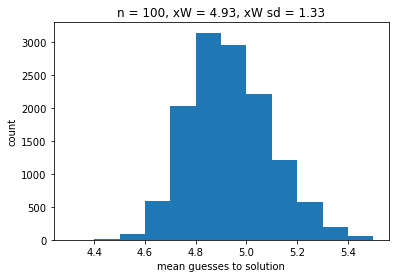

In [707]:
df_chart = df_summary["mean_guesses"]
plt.hist(df_chart, bins=np.arange(4.3,5.5, 0.1))
xW = df_full["number_guesses"].mean()
xW_sd = df_full["number_guesses"].std()

title = "n = 100, xW = {xW:.2f}, xW sd = {xW_sd:.2f}"
plt.title(title.format(xW = xW, xW_sd = xW_sd))
plt.xlabel("mean guesses to solution")
plt.ylabel("count");

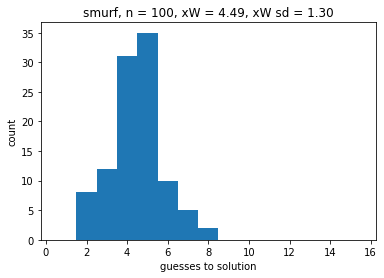

In [748]:
first_guess = "smurf"
df_chart = df_full[df_full["first_guess"] == first_guess]["number_guesses"]
xW = df_full[df_full["first_guess"] == first_guess]["number_guesses"].mean()
xW_sd = df_full[df_full["first_guess"] == first_guess]["number_guesses"].std()


plt.hist(df_chart, bins=np.arange(0.5,16.5))
title = first_guess + ", n = 100, xW = {xW:.2f}, xW sd = {xW_sd:.2f}"
plt.title(title.format(xW = xW, xW_sd = xW_sd))
plt.xlabel("guesses to solution")
plt.ylabel("count");

Below we compare the distributions for two solutions (using bootstrapping) to see if they are materially different.

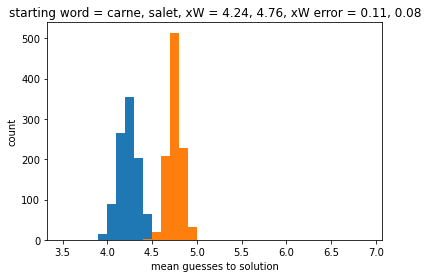

In [721]:
word_a = "carne"
word_b = "salet"

list_a = list(df_full[df_full["first_guess"] == word_a]["number_guesses"].values)
list_b = list(df_full[df_full["first_guess"] == word_b]["number_guesses"].values)

list_a_mean = []

for i in range(1000):
    list_temp = []
    for j in range(len(list_a)):
        pick = random.choice(list_a)
        list_temp.append(pick)
    list_a_mean.append(np.array(list_temp).mean())

list_b_mean = []
for i in range(1000):
    list_temp = []
    for j in range(len(list_b)):
        pick = random.choice(list_b)
        list_temp.append(pick)
    list_b_mean.append(np.array(list_temp).mean())
    

xW_a = np.array(list_a_mean).mean()    
xW_b = np.array(list_b_mean).mean()
xW_a_sd = np.array(list_a_mean).std()    
xW_b_sd = np.array(list_b_mean).std()
    
    
plt.hist(list_a_mean, bins=np.arange(3.5,7, 0.1))
plt.hist(list_b_mean, bins=np.arange(3.5,7, 0.1))
title = "starting word = " + word_a + ", " + word_b + f", xW = {xW_a:.2f}, {xW_b:.2f}, xW error = {xW_a_sd:.2f}, {xW_b_sd:.2f}"
plt.title(title)
plt.xlabel("mean guesses to solution")
plt.ylabel("count");